# Explore here

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, RocCurveDisplay
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn.impute import KNNImputer
import joblib

url = "https://breathecode.herokuapp.com/asset/internal-link?id=930&path=diabetes.csv"

In [3]:
df = pd.read_csv(url)

In [4]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [6]:
df.shape


(768, 9)

In [7]:
df.describe().T


,count,mean,std,min,25%,50%,75%,max
Pregnancies,768.0,3.845052,3.369578,0.000,1.00000,3.0000,6.00000,17.00
Glucose,768.0,120.894531,31.972618,0.000,99.00000,117.0000,140.25000,199.00
BloodPressure,768.0,69.105469,19.355807,0.000,62.00000,72.0000,80.00000,122.00
SkinThickness,768.0,20.536458,15.952218,0.000,0.00000,23.0000,32.00000,99.00
Insulin,768.0,79.799479,115.244002,0.000,0.00000,30.5000,127.25000,846.00
BMI,768.0,31.992578,7.884160,0.000,27.30000,32.0000,36.60000,67.10
DiabetesPedigreeFunction,768.0,0.471876,0.331329,0.078,0.24375,0.3725,0.62625,2.42
Age,768.0,33.240885,11.760232,21.000,24.00000,29.0000,41.00000,81.00
Outcome,768.0,0.348958,0.476951,0.000,0.00000,0.0000,1.00000,1.00


Podemos ver en la información que hemos sacado que no hay nulos, pero sospecho que aqui los nulos fueron remplazados por 0s, ya que hay gente sin glucosa, sin presión sanguinea, sin SkinThickness → Grosor de la piel, insulina o BMI → Índice de Masa Corporal (IMC).

Asi que procederemos a ver que podemos hacer con ello.

In [8]:
cols_with_zeros = ["Glucose", 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
(df[cols_with_zeros] == 0).sum()

Glucose            5
BloodPressure     35
SkinThickness    227
Insulin          374
BMI               11
dtype: int64

Podemos ver que los 0 donde no deberia haber de manera normal o aceptada.
En la Glucose, BloodPressure y BMI, no hay tanto problema.
Pero en Insulin (casi 50%) y SkinThickness (casi 30%) son muchos nulos.

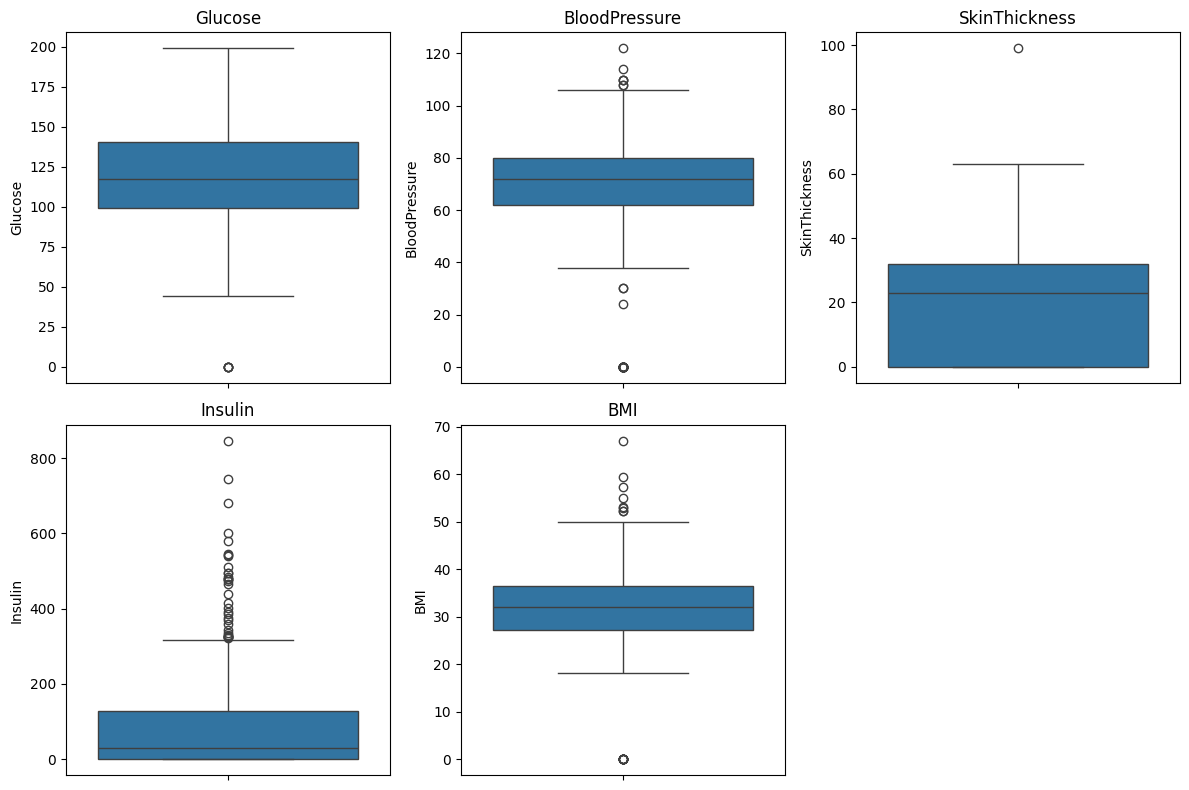

In [9]:
plt.figure(figsize=(12,8))

for i, col in enumerate(cols_with_zeros, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(y=df[col])
    plt.title(col)

plt.tight_layout()
plt.show()


Vemos todos los casos que se salen de lo normal y son muy fuera de lo comun pasando los limites superiores y inferiores.

A continuación, procederemos a reemplazar los valores atípicos (outliers) (COMO EXPERIMENTO)

In [10]:
df_col_outliers = df[cols_with_zeros]

In [11]:
def remove_outliers(x, allow_neg=True):
    q1, q3 = x.quantile([0.25, 0.75])
    iqr = q3 - q1
    upper_lim = q3 + (iqr*1.5)
    lower_lim = q1 - (iqr*1.5) if allow_neg else max(0, q1 - (iqr * 1.5))

    x = x.apply(lambda x: upper_lim if (x > upper_lim) else (lower_lim if (x < lower_lim) else x))


    return x

In [12]:
for col in df_col_outliers:
    df_col_outliers[col] = remove_outliers(df_col_outliers[col])

/tmp/ipykernel_922/3329583128.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_col_outliers[col] = remove_outliers(df_col_outliers[col])
/tmp/ipykernel_922/3329583128.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_col_outliers[col] = remove_outliers(df_col_outliers[col])
/tmp/ipykernel_922/3329583128.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: htt

In [13]:
df_col_outliers.describe()

,Glucose,BloodPressure,SkinThickness,Insulin,BMI
count,768.000000,768.000000,768.000000,768.000000,768.000000
mean,121.136230,70.684896,20.511719,73.652669,32.125065
std,31.187468,14.197239,15.844744,93.576029,7.049584
min,37.125000,35.000000,0.000000,0.000000,13.350000
25%,99.000000,62.000000,0.000000,0.000000,27.300000
50%,117.000000,72.000000,23.000000,30.500000,32.000000
75%,140.250000,80.000000,32.000000,127.250000,36.600000
max,199.000000,107.000000,80.000000,318.125000,50.550000


In [14]:
cols_with_zeros = ["Glucose", 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
(df_col_outliers == 0).sum()

Glucose            0
BloodPressure      0
SkinThickness    227
Insulin          374
BMI                0
dtype: int64

Al hacer este experimento podemos ver que se han solucionado las columnas con menos nulos pero las que más nulos predominan no cambian, así que probaré a usar KNN.

In [15]:
# 1 Seleccionamos las columnas con ceros no válidos
cols_with_zeros = ['SkinThickness', 'Insulin']

# 2 Reemplazamos los ceros por NaN (para que KNNImputer los detecte)
df[cols_with_zeros] = df[cols_with_zeros].replace(0, np.nan)

# 3 Inicializamos el KNNImputer (k=5 suele funcionar bien)
imputer = KNNImputer(n_neighbors=5)

# 4 Aplicamos el imputador a todo el DataFrame (mejor contexto entre columnas)
df_imputed = imputer.fit_transform(df)

# 5 Reconstruimos el DataFrame original con los valores imputados
df = pd.DataFrame(df_imputed, columns=df.columns)

# 6 Comprobamos si aún quedan valores nulos
print(df[cols_with_zeros].isnull().sum())

SkinThickness    0
Insulin          0
dtype: int64


Ahora que no tenemos nulos procedemos a escalar los datos y dividir en trein y test

In [16]:
X = df.drop('Outcome', axis=1)
y = df['Outcome']

In [17]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [18]:
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

Ahora optimizaremos K

In [19]:
k_range = range(1, 21)
scores = []

In [20]:
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    # Validación cruzada de 5 particiones (cv=5)
    score = cross_val_score(knn, X_scaled, y, cv=10, scoring='accuracy').mean()
    scores.append(score)

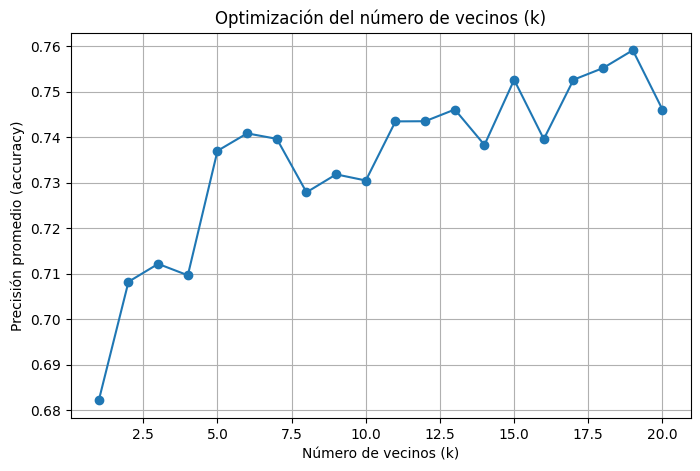

In [21]:
plt.figure(figsize=(8,5))
plt.plot(k_range, scores, marker='o')
plt.title("Optimización del número de vecinos (k)")
plt.xlabel("Número de vecinos (k)")
plt.ylabel("Precisión promedio (accuracy)")
plt.grid(True)
plt.show()

In [22]:
best_k = k_range[scores.index(max(scores))]
print(f"🔹 El mejor valor de k es: {best_k} con una precisión promedio de {max(scores):.3f}")

🔹 El mejor valor de k es: 19 con una precisión promedio de 0.759


Ahora entrenamos el modelo 

In [23]:
knn = KNeighborsClassifier(n_neighbors=16)
knn.fit(X_train, y_train)

,n_neighbors,16
,weights,'uniform'
,algorithm,'auto'
,leaf_size,30
,p,2
,metric,'minkowski'
,metric_params,None
,n_jobs,None


In [24]:
y_pred = knn.predict(X_test)

print(f"\nRESULTADOS DEL MODELO KNN (k={best_k}) ")
print("Accuracy:", round(accuracy_score(y_test, y_pred), 3))
print("\nMatriz de confusión:\n", confusion_matrix(y_test, y_pred))
print("\nReporte de clasificación:\n", classification_report(y_test, y_pred))


RESULTADOS DEL MODELO KNN (k=19) 
Accuracy: 0.753

Matriz de confusión:
 [[88 12]
 [26 28]]

Reporte de clasificación:
               precision    recall  f1-score   support

         0.0       0.77      0.88      0.82       100
         1.0       0.70      0.52      0.60        54

    accuracy                           0.75       154
   macro avg       0.74      0.70      0.71       154
weighted avg       0.75      0.75      0.74       154



In [ ]:
# Crear el modelo
dt = DecisionTreeClassifier(
    criterion="gini",   
    max_depth=None,    
    random_state=42
)

# Entrenar
dt.fit(X_train, y_train)

# Predecir
y_pred = dt.predict(X_test)

# Métricas
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

Accuracy: 0.6753246753246753

Classification Report:
               precision    recall  f1-score   support

         0.0       0.75      0.75      0.75       100
         1.0       0.54      0.54      0.54        54

    accuracy                           0.68       154
   macro avg       0.64      0.64      0.64       154
weighted avg       0.68      0.68      0.68       154


Confusion Matrix:
 [[75 25]
 [25 29]]
